In [1]:
import fanc
import fanc.plotting
import chess
from os import path
import logging
import numpy as np
from scipy import ndimage as ndi
from skimage import restoration
from skimage.morphology import square, closing
import skimage.filters as filters
from skimage.measure import label, regionprops
from numpy import inf
from scipy.ndimage import zoom
import warnings
from future.utils import string_types
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
%matplotlib inline

from chess.helpers import (
    load_regions, load_sparse_matrix, sub_matrix_from_edges_dict
    )
from chess.helpers import load_pairs_iter, load_oe_contacts
from chess.get_structures import clipped_zoom

# Extract structures: example walkthrough

The aim of this document is to walkthrough all the steps involved in `chess extract` in order to visualise the effects of choosing different parameters at each step. 

## Load data

In [2]:
query_matrix_file = "ukm_patient_fixed_le_25kb_chr2.hic"
reference_matrix_file = "ukm_control_fixed_le_25kb_chr2.hic"

reference_edges, reference_region_trees, reference_regions = load_oe_contacts(reference_matrix_file, None)
query_edges, query_region_trees, query_regions = load_oe_contacts(query_matrix_file, None)

In [3]:
output = "./"
gained_features_file = path.join(output, 'gained_features.csv')
lost_features_file = path.join(output, 'lost_features.csv')


For the purposes of this document, we'll specify a single region of interest. 

In [4]:
reference_region = query_region = fanc.GenomicRegion.from_string("chr2:144800001-147800001")
pos_query = 0
pos_reference = 0
pair_ix = 0

In [5]:
reference, ref_rs = sub_matrix_from_edges_dict(
    reference_edges,
    reference_regions,
    reference_region,
    default_weight=0.)
query, qry_rs = sub_matrix_from_edges_dict(
    query_edges,
    query_regions,
    query_region,
    default_weight=0.)

size = np.shape(query)[0]

or_matrix = np.log(np.divide(query, reference))
where_are_NaNs = np.isnan(or_matrix)
or_matrix[where_are_NaNs] = 0.
or_matrix[or_matrix == -inf] = 0.
or_matrix[or_matrix == inf] = 0.
std = np.std(or_matrix)

positive = np.where(or_matrix > (0.5 * std), or_matrix, 0.)
negative = np.abs(np.where(or_matrix < -(0.5 * std), or_matrix, 0.))

## Separate contacts that are lost/gained between reference and query

The `positive` and `negative` matrices represent contacts that are higher in the query or in the reference, respectively. 

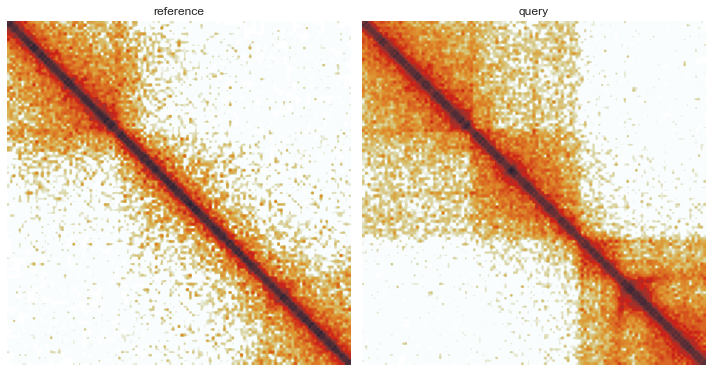

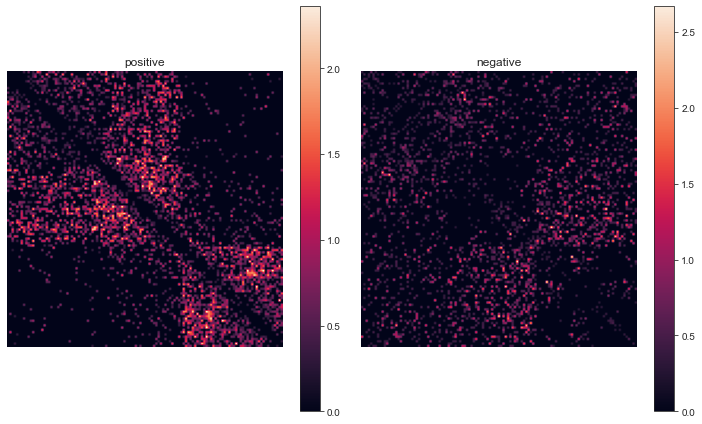

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
ax1.imshow(reference, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')
ax1.set_axis_off()
ax2.imshow(query, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')
ax2.set_axis_off()

ax1.set_title('reference')
ax2.set_title('query')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
pos = ax1.imshow(positive)
fig.colorbar(pos, ax=ax1)
neg = ax2.imshow(negative)
fig.colorbar(neg, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('positive')
ax2.set_title('negative')
plt.tight_layout()
plt.show()


## Denoise and smooth matrices

The `positive` and `negative` matrices are then denoised and smoothed. The `windowsize` and `sigma_spatial` parameters are used for denoising.

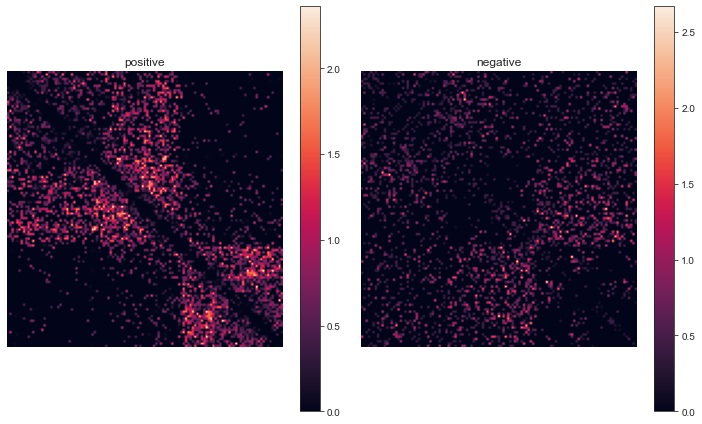

In [7]:
windowsize = 3
sigma_spatial = 3
# denoise
denoise_positive = restoration.denoise_bilateral(
    positive,
    sigma_color=np.mean(positive),
    win_size=windowsize,
    sigma_spatial=sigma_spatial,
    bins=size,
    multichannel=False)
denoise_negative = restoration.denoise_bilateral(
    negative,
    sigma_color=np.mean(negative),
    win_size=windowsize,
    sigma_spatial=sigma_spatial,
    bins=size,
    multichannel=False)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
pos = ax1.imshow(denoise_positive)
fig.colorbar(pos, ax=ax1)
neg = ax2.imshow(denoise_negative)
fig.colorbar(neg, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('positive')
ax2.set_title('negative')
plt.tight_layout()
plt.show()

The `size_medianfilter` parameter is used for smoothing.

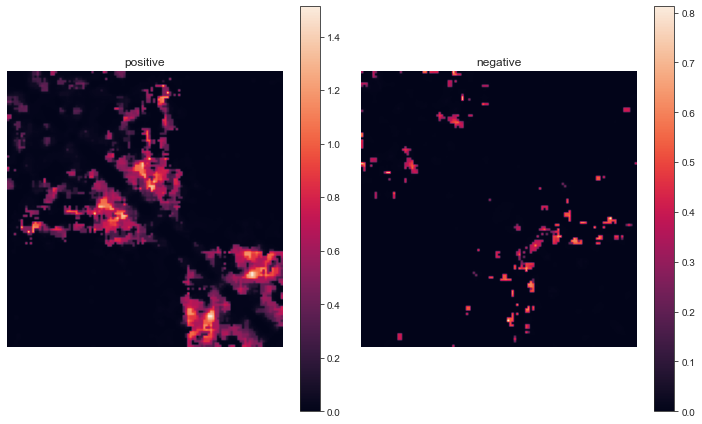

In [8]:
size_medianfilter = 4

# smooth
filter_positive = ndi.median_filter(
    denoise_positive, size_medianfilter)
filter_negative = ndi.median_filter(
    denoise_negative, size_medianfilter)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
pos = ax1.imshow(filter_positive)
fig.colorbar(pos, ax=ax1)
neg = ax2.imshow(filter_negative)
fig.colorbar(neg, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('positive')
ax2.set_title('negative')
plt.tight_layout()
plt.show()

## Binarising

The smoothed matrices are binarised using a threshold calculated using the Otsu method. 

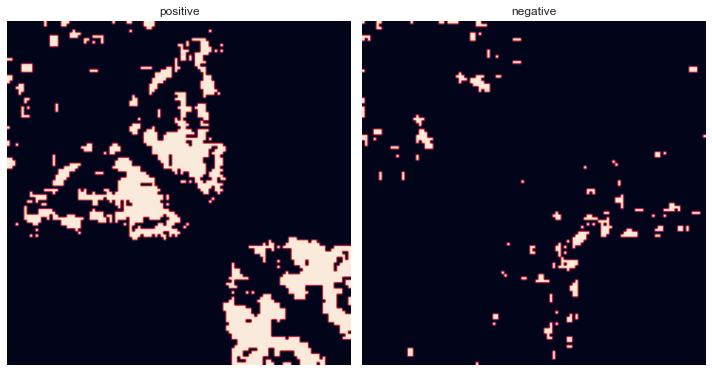

In [9]:
# binarise
if np.all(filter_positive == 0.):
    threshold_pos = positive
else:
    filter1 = filters.threshold_otsu(filter_positive, nbins=size)
    threshold_pos = filter_positive > filter1

if np.all(filter_negative == 0.):
    threshold_neg = negative
else:
    filter2 = filters.threshold_otsu(filter_negative, nbins=size)
    threshold_neg = filter_negative > filter2

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
pos = ax1.imshow(threshold_pos)
neg = ax2.imshow(threshold_neg)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.set_title('positive')
ax2.set_title('negative')
plt.tight_layout()
plt.show()


## Feature identification

Features of interest are identified using morphological closing. Features that pass a minimum size threshold are retained and visualised as rectangles overlaid on top of the binarised matrix. 

N.B., feature size can be calculated in two ways. One is `feature.area`, i.e. the number of non-zero pixels in the feature. The other is `feature.bbox_area`, the area of the bounding box that encloses the feature. The latter may be more intuitive to understand?

Minimum feature size is currently defined as `feature.area` more than 5% of the width of the query matrix in pixels. It might be helpful to make this another parameter the user can choose. 

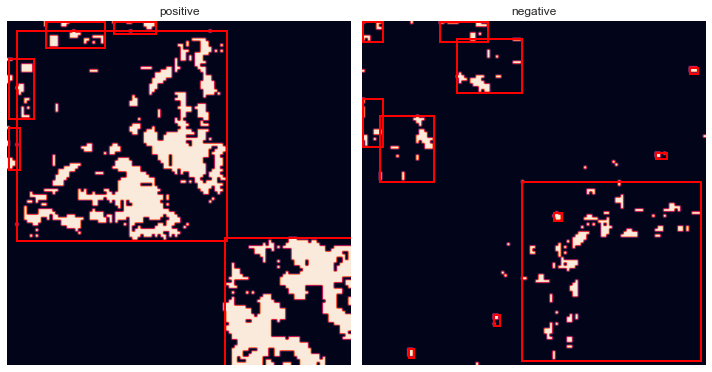

In [10]:
closing_square = 8
area = int((5 * np.shape(query)[0]) / 100)

# Close morphology
img1 = closing(threshold_pos, square(closing_square))
label_x1 = label(img1)
img2 = closing(threshold_neg, square(closing_square))
label_x2 = label(img2)


fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
ax1.imshow(threshold_pos)

for region in regionprops(label_x1):
    # take regions with large enough areas
    if region.bbox_area >= area:
        # print(region.area / region.bbox_area, region.bbox_area)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)

ax1.set_axis_off()

ax2.imshow(threshold_neg)

for region in regionprops(label_x2):
    # take regions with large enough areas
    if region.bbox_area >= area:
        # print(region.area / region.bbox_area, region.bbox_area)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)

ax2.set_axis_off()
ax1.set_title('positive')
ax2.set_title('negative')
plt.tight_layout()
plt.show()

The features can also be visualised as overlays on top of the original query and reference matrices. Here they are highlighted on the matrix where the feature is present / stronger. 

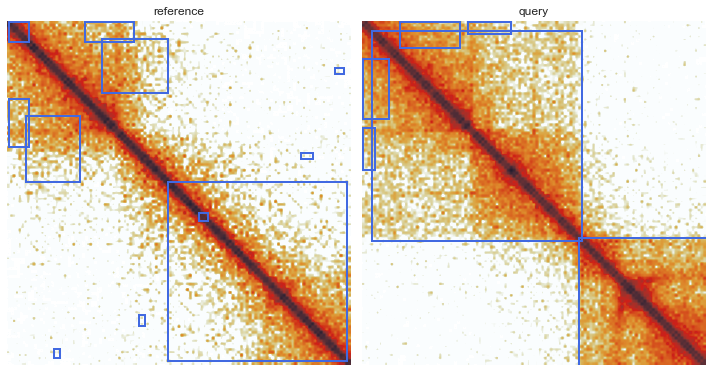

In [11]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
ax1.imshow(reference, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')

# higher in ref
for region in regionprops(label_x2):
    # take regions with large enough areas
    if region.area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
        ax1.add_patch(rect)
ax1.set_axis_off()

ax2.imshow(query, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')

# higher in query
for region in regionprops(label_x1):
    # take regions with large enough areas
    if region.area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
        ax2.add_patch(rect)
ax2.set_axis_off()
ax1.set_title('reference')
ax2.set_title('query')
plt.tight_layout()
plt.show()

## Exporting feature coordinates and matrix values

Finally, features can be exported to file. The `get_info_feature` function outputs comma-separated data with the following columns:

* region ID (same as in the chess sim output)
* feature index within the region
* bounding box coordinates relative to the region submatrix (xmin, xmax, ymin and ymax)
* bounding box coordinates as genomic coordinates
* the remaining columns contain the contact values for the portion of the region matrix belonging to the feature in the query matrix (gained_features.tsv) or reference matrix (lost_features.tsv).

N.B., since the matrices are symmetric, some features will appear twice in the output. 

To do: 
* include region in genomic coordinates in output?
* remove duplicated features from output
* test `chess crosscorelate` performance on features output by this version of `chess extract`

In [12]:
# get Hi-C bin size / resolution in bp
# needed for calculating genomic coordinates from pixel coordinates
hic_bin_size = reference_regions[0].end - reference_regions[0].start + 1
pos_query = chess.get_info_feature_square(
            label_x1, query, gained_features_file, pos_query, query_region, area, pair_ix, hic_bin_size)
pos_reference = chess.get_info_feature_square(
            label_x2, reference, lost_features_file, pos_reference, reference_region, area, pair_ix, hic_bin_size)

## Comparison to original approach

The original `chess extract` approach first rotated matrices by 45 degrees and shrunk them slightly. This enables nice visualisation, but makes it tricky to link extracted matrix features to genomic coordinates. 

Using exacty the same steps for matrix smoothing, thresholding, and featrues identification leads to different extracted features because of these additional matrix manipulation steps, so results are not directly comparable. 

Below, the same steps with the same parameters are carried out on the rotated, zoomed matrices and the resulting features are visualised as a demonstration. 

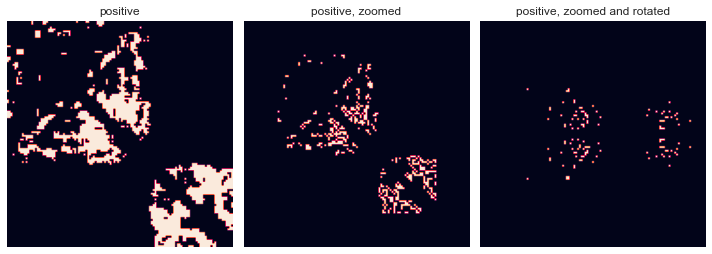

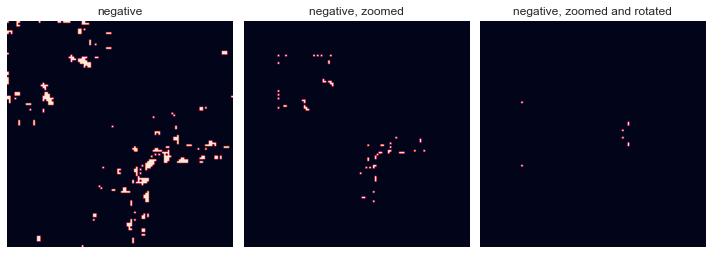

In [13]:
# zoom and rotate 45 degrees
zm1 = clipped_zoom(threshold_pos, 0.7)
rot1 = ndi.rotate(zm1, 45, reshape=False)
zm2 = clipped_zoom(threshold_neg, zoom_factor=0.7)
rot2 = ndi.rotate(zm2, 45, reshape=False)


fig, (ax0, ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 3)
pos = ax0.imshow(threshold_pos)
pos_zm = ax1.imshow(zm1)
pos_rot = ax2.imshow(rot1)
ax0.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()
ax0.set_title('positive')
ax1.set_title('positive, zoomed')
ax2.set_title('positive, zoomed and rotated')
plt.tight_layout()
plt.show()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 3)
pos = ax0.imshow(threshold_neg)
pos_zm = ax1.imshow(zm2)
pos_rot = ax2.imshow(rot2)
ax0.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()
ax0.set_title('negative')
ax1.set_title('negative, zoomed')
ax2.set_title('negative, zoomed and rotated')
plt.tight_layout()
plt.show()

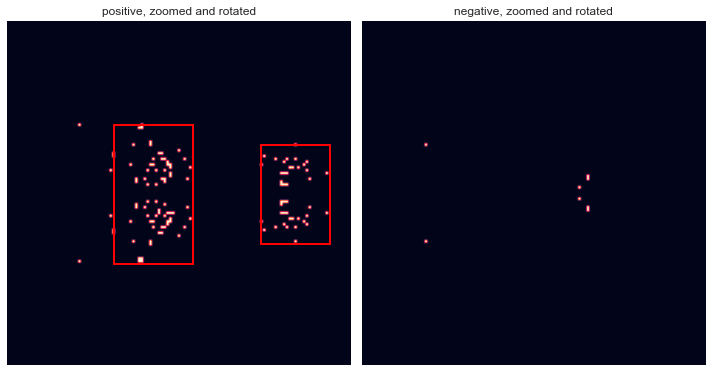

In [14]:
# Close morphology
img1 = closing(rot1, square(closing_square))
label_x1 = label(img1)
img2 = closing(rot2, square(closing_square))
label_x2 = label(img2)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
ax1.imshow(rot1)

for region in regionprops(label_x1):
    #print(region.area / region.bbox_area, region.bbox_area)
    # take regions with large enough areas
    if region.bbox_area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)

ax1.set_axis_off()

ax2.imshow(rot2)

for region in regionprops(label_x2):
   # print(region.area / region.bbox_area, region.bbox_area)
    # take regions with large enough areas
    if region.bbox_area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)

ax2.set_axis_off()

ax1.set_title('positive, zoomed and rotated')
ax2.set_title('negative, zoomed and rotated')
plt.tight_layout()
plt.show()

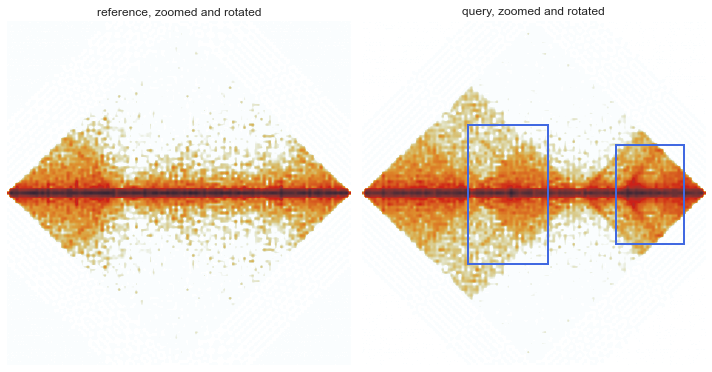

In [15]:
# clipped zoom and rotate patient and control and keep only half-matrix
zm1 = clipped_zoom(reference, 0.7)
rot_ref = ndi.rotate(zm1, 45, reshape=False)
zm2 = clipped_zoom(query, 0.7)
rot_query = ndi.rotate(zm2, 45, reshape=False)


fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols = 2)
ax1.imshow(rot_ref, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')
# higher in ref
for region in regionprops(label_x2):
    # take regions with large enough areas
    if region.bbox_area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
        ax1.add_patch(rect)
ax1.set_axis_off()

ax2.imshow(rot_query, norm=LogNorm(vmin=1e-3, vmax=1e-1), cmap='germany')
# higher in query
for region in regionprops(label_x1):
    # take regions with large enough areas
    if region.bbox_area >= area:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
        ax2.add_patch(rect)
ax2.set_axis_off()

ax1.set_title('reference, zoomed and rotated')
ax2.set_title('query, zoomed and rotated')

plt.tight_layout()
plt.show()
